# Исследование рынка видеоигр

**Исходные данные:** исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы.

**Цель работы:** выявить определяющие успешность игры закономерности для определения потенциально популярного продукта и планирования рекламной компании на 2017 год.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
pd.set_option('display.float_format', '{:.2f}'.format)

import warnings
warnings.filterwarnings('ignore')

## Первичный анализ данных

In [2]:
data = pd.read_csv('//datasets//games.csv')  # считываем датасет в переменную data

In [3]:
display(data)  # выводим данные для ознакомления
print(data.info())  # выводим общую информацию о датасете
display(data.describe().T)  # выводим статистическую информацию о датасете
print('Явных дубликатов:', data.duplicated().sum())  # проверяем датасет на явные дубликаты

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.00,Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,1985.00,Platform,29.08,3.58,6.81,0.77,nan,NaN,NaN
2,Mario Kart Wii,Wii,2008.00,Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,2009.00,Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.00,Role-Playing,11.27,8.89,10.22,1.00,nan,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.00,Action,0.00,0.00,0.01,0.00,nan,NaN,NaN
16711,LMA Manager 2007,X360,2006.00,Sports,0.00,0.01,0.00,0.00,nan,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.00,Adventure,0.00,0.00,0.01,0.00,nan,NaN,NaN
16713,Spirits & Spells,GBA,2003.00,Platform,0.01,0.00,0.00,0.00,nan,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None


,count,mean,std,min,25%,50%,75%,max
Year_of_Release,16446.00,2006.48,5.88,1980.00,2003.00,2007.00,2010.00,2016.00
NA_sales,16715.00,0.26,0.81,0.00,0.00,0.08,0.24,41.36
EU_sales,16715.00,0.15,0.50,0.00,0.00,0.02,0.11,28.96
JP_sales,16715.00,0.08,0.31,0.00,0.00,0.00,0.04,10.22
Other_sales,16715.00,0.05,0.19,0.00,0.00,0.01,0.03,10.57
Critic_Score,8137.00,68.97,13.94,13.00,60.00,71.00,79.00,98.00


Явных дубликатов: 0


Из описания данных:
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

**Выводы**
1. Данные импортированы успешно
2. Представлены данные по играм, выпущенным в период с 1980 по 2016 год.
3. В данные есть пропуски (NaN), которые, возможно, надо обработать. Столбцы с пропусками:
    1. Имя (всего два пропуска)
    2. Год выпуска (пропусков немного, надо разбираться)
    3. Жанр (возможно, игра не попадает не под один из жанров, тоже всего два пропуска)
    4. Оценка критиков (возможно, игра не оценивалась критиками из-за малых продаж)
    5. Оценка пользователей (возможно, игра не оценивалась пользователями из-за малых продаж)
    6. Рейтинг (возможно, рейтинг игре не присваивался, так как игра вышла на локальном рынке)
4. У ряда столбцов надо скорректировать тип данных:
    1. Год релиза - проще перевести в целочисленный формат. Формат datetime в данном случае не имеет смысла.
    2. Оценки пользователей - необходим формат вещественный формат

## Подготовка данных

### Переименование столбцов

In [4]:
# переименование столбцов в соответствии со snake_case
data.columns = data.columns.str.lower()

### Преобразование типов данных

#### Столбец `year_of_release`

Данный столбец содержит информацию о годе выпуска игры, а значит его можно перевести в целочисленный формат.

In [5]:
data['year_of_release'].unique()  # проверим, на всякий случай, какие значения встречаются

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983.])

Перед преобразованием необходимо разобраться с пропусками.

In [6]:
data[data['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,nan,Sports,4.26,0.26,0.01,0.71,94.00,8.5,E
377,FIFA Soccer 2004,PS2,nan,Sports,0.59,2.36,0.04,0.51,84.00,6.4,E
456,LEGO Batman: The Videogame,Wii,nan,Action,1.80,0.97,0.00,0.29,74.00,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,nan,Fighting,1.57,1.02,0.00,0.41,nan,NaN,NaN
609,Space Invaders,2600,nan,Shooter,2.36,0.14,0.00,0.03,nan,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,nan,Sports,0.01,0.00,0.00,0.00,43.00,tbd,E10+
16405,Freaky Flyers,GC,nan,Racing,0.01,0.00,0.00,0.00,69.00,6.5,T
16448,Inversion,PC,nan,Shooter,0.01,0.00,0.00,0.00,59.00,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,nan,Adventure,0.01,0.00,0.00,0.00,nan,NaN,NaN


Год выхода игры для данного исследования является важным параметром, часть игр содержит в названии год выхода. Попробуем заполнить автоматически.

In [7]:
data[(data['genre'] == 'Sports') & (data['name'].str.contains('\d{4}', regex=True))].head(20)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,nan,Sports,4.26,0.26,0.01,0.71,94.00,8.5,E
238,Madden NFL 2005,PS2,2004.00,Sports,4.18,0.26,0.01,0.08,91.00,7.9,E
250,Winning Eleven: Pro Evolution Soccer 2007,PS2,2006.00,Sports,0.10,2.39,1.05,0.86,86.00,8.9,E
283,Madden NFL 2003,PS2,2002.00,Sports,3.36,0.21,0.01,0.56,95.00,7.7,E
333,Mario & Sonic at the London 2012 Olympic Games,Wii,2011.00,Sports,1.12,1.87,0.27,0.45,nan,NaN,NaN
338,FIFA Soccer 2005,PS2,2004.00,Sports,0.58,2.48,0.04,0.59,81.00,7.6,E
349,Pro Evolution Soccer 2008,PS2,2007.00,Sports,0.05,0.00,0.64,2.93,82.00,7.9,E
377,FIFA Soccer 2004,PS2,nan,Sports,0.59,2.36,0.04,0.51,84.00,6.4,E
393,FIFA Soccer 2003,PS2,2002.00,Sports,0.46,2.28,0.05,0.61,88.00,6.7,E
452,Madden NFL 2002,PS2,2001.00,Sports,2.50,0.16,0.01,0.42,94.00,7.9,E


In [8]:
def year_finder(string):
    for string_part in string.split():  # преобразуем название игры в список, разделив по пробелам
        if string_part.isdigit():  # если какая-то часть списка состоит только из цифр
            if 1980 <= int(string_part) <= 2016:  # и находится в диапазоне от 1980 до 2016
                return int(string_part)  # то это, скорее всего, дата выхода игры

In [9]:
data.loc[(data['year_of_release'].isna()) & (data['genre'] != 'Sports'), 'year_of_release'] = data.loc[(data['year_of_release'].isna()) & (data['genre'] != 'Sports'), 'name'].apply(year_finder)

In [10]:
def year_finder_sports(string):
    if year_finder(string):
        return (year_finder(string) - 1)

In [11]:
data.loc[(data['year_of_release'].isna()) & (data['genre'] == 'Sports'), 'year_of_release'] = data.loc[(data['year_of_release'].isna()) & (data['genre'] == 'Sports'), 'name'].apply(year_finder_sports)

Остальные пропущенные значения проще отфильтровать при необходимости.

In [12]:
data[data['year_of_release'].isna()]['platform'].value_counts()  # для каких платформ отсутствуют годы выхода игр
# если платформа новая, то игру было бы целесообразно оставить
# все платформы относительно старые, данные можно удалить без особых последствий

Wii     34
DS      29
X360    28
PS2     27
PS3     25
XB      18
2600    17
PC      17
PSP     15
GC      13
GBA     11
3DS      8
PS       7
N64      3
PSV      1
GB       1
Name: platform, dtype: int64

In [13]:
data.dropna(axis=0, subset=['year_of_release'], inplace=True)  # исключаем игры без года выпуска
data['year_of_release'] = data['year_of_release'].astype(int)  # преобразуем года к целочисленному типу

#### Столбец `user_score`

Данный столбец содержит информацию об оценках пользователей, а значит должен иметь вещественный формат. Но сначала надо разобраться, что в нём содержится

In [14]:
data['user_score'].value_counts()

tbd    2378
7.8     322
8       285
8.2     277
8.3     252
       ... 
0.3       2
1.5       2
1.1       2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64

Большинство строк содержит аббревиатуру `tbd` - наиболее вероятное значение `To Be Determined` или `подлежит определению`.

In [15]:
data.query('user_score == "tbd"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.00,0.66,nan,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.00,0.54,61.00,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.00,0.27,nan,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.00,0.20,71.00,tbd,E
718,Just Dance Kids,Wii,2010,Misc,1.52,0.54,0.00,0.18,nan,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001,Action,0.01,0.00,0.00,0.00,67.00,tbd,E
16697,Bust-A-Move 3000,GC,2003,Puzzle,0.01,0.00,0.00,0.00,53.00,tbd,E
16698,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.00,0.00,48.00,tbd,E
16704,Plushees,DS,2008,Simulation,0.01,0.00,0.00,0.00,nan,tbd,E


Каких-то явных закономерностей нет, можно предположить, что на игру не набралось достаточно пользовательских оценок для объективного выставления рейтинга. Можно заполнить пропусками.

In [16]:
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')

### Обработка пропусков

#### Столбец `name`

В данном столбце встречаются всего два пропуска. Изучим их поближе.

In [17]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,nan,nan,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,nan,nan,NaN


Строки содержат только информацию о величине продаж двух непонятных игр в 1993 году для Sega Genesis. Вряд ли нам пригодится данная информация. Можно в дальнейшем исключить исключить.

In [18]:
data.dropna(axis=0, subset=['name'], inplace=True)
data.reset_index(drop=True, inplace=True)

#### Столбцы `critic_score` и `user_score`

Заполнять данные в столбцах медианным или средним значением было бы некорректно, так как это привело бы к искажению данных для дальнейшего анализа.

#### Столбец `rating`

In [19]:
data['rating'].value_counts(dropna=False)  # проверим содержание столбца

NaN     6681
E       3930
T       2905
M       1536
E10+    1394
EC         8
K-A        3
RP         1
AO         1
Name: rating, dtype: int64

Описаение рейтингов

* E - Everyone
* T - Teen
* M - Mature
* E10+ - Everyone 10+
* EC - Early childhood
* RP - Rating Pending
* K-A - for Kids to Adults
* AO - Adults Only 18+

Пропущенные значения заменим на `NR`

In [20]:
data['rating'].fillna('NR', inplace=True)

### Столбец с суммарными продажами `ttl_sales`

In [21]:
data['ttl_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

## Исследовательский анализ данных

### Количество выпусков игр по годам

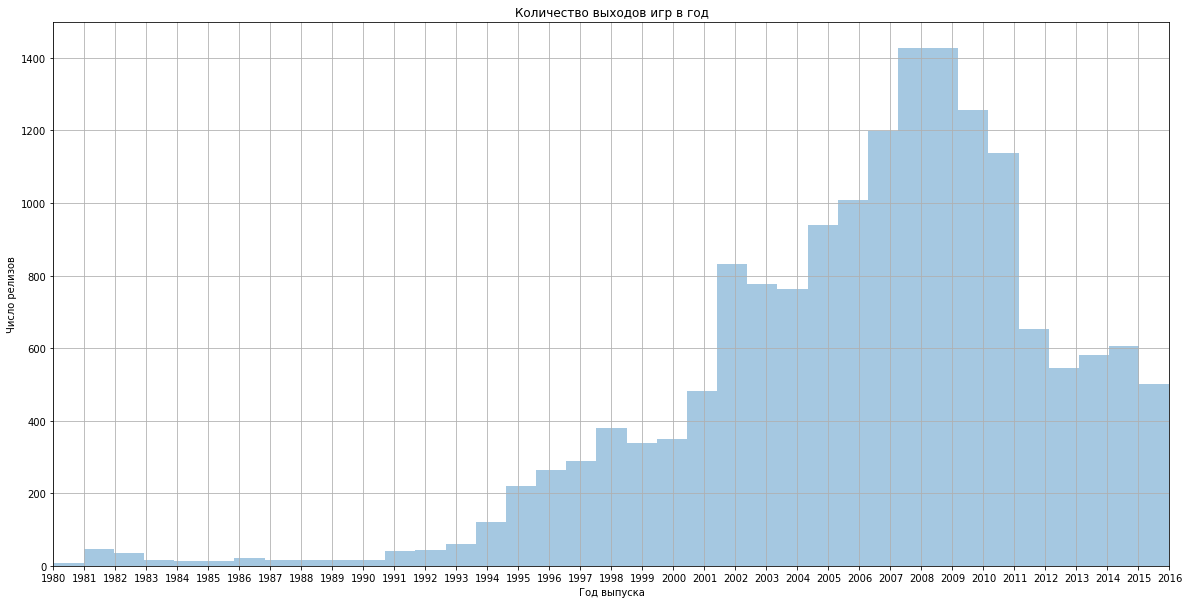

In [22]:
plt.figure(figsize=(20, 10))
sns.distplot(data['year_of_release'],
             bins=37,
             hist=True,
             kde=False)
plt.grid(True)
plt.xlim(1980, 2016)
plt.xticks(range(1980, 2017))
plt.xlabel('Год выпуска')
plt.ylabel('Число релизов')
plt.title('Количество выходов игр в год')
plt.show()

**Выводы**
1. Игры до 1995 годов выпускались в сравнительно небольшом объёме, не более 200 релизов в год.
2. С 2006 по 2011 наблюдается наибольшее число релизов в год.
3. В период с 2012 по 2016 год число релизов игр резко снизилось. Можно предположить следующее:
    1. С развитием технологий стоимость разработки возрасла, и теперь доступна только крупным студиям.
    2. Жизненный цикл основных платформ подошел к концу, а новые еще не появились.

### Анализ продаж игр по платформам

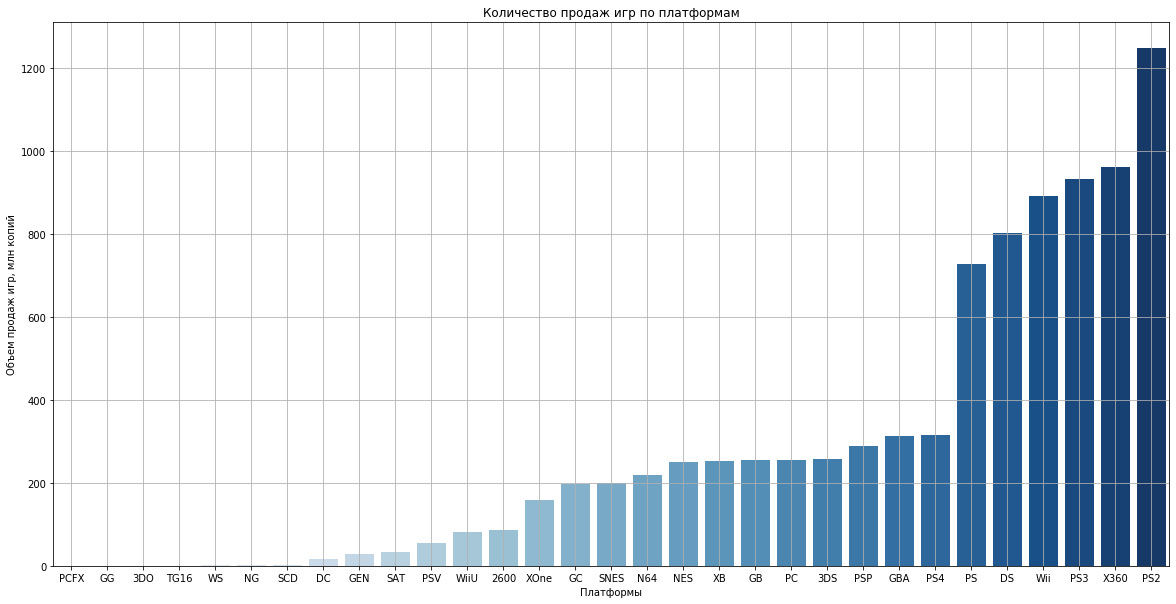

In [23]:
platform_ttl_sales = data.groupby('platform')['ttl_sales'].sum().sort_values()
plt.figure(figsize=(20, 10))
sns.barplot(x=platform_ttl_sales.index,
            y=platform_ttl_sales,
            palette='Blues')
plt.grid(True)
plt.xlabel('Платформы')
plt.ylabel('Объем продаж игр, млн копий')
plt.title('Количество продаж игр по платформам')
plt.show()

Для дальнейшего анализа оставим платформы, для которых продано игр в количестве более 50 млн копий

In [24]:
platform_ttl_sales = platform_ttl_sales[platform_ttl_sales > 50].index

In [25]:
platform_ttl_sales = data[data['platform'].isin(platform_ttl_sales)].pivot_table(index='platform', columns='year_of_release', values='ttl_sales', aggfunc=(sum)).sort_values(by=[x for x in range(2016, 1982, -1)], ascending=False)

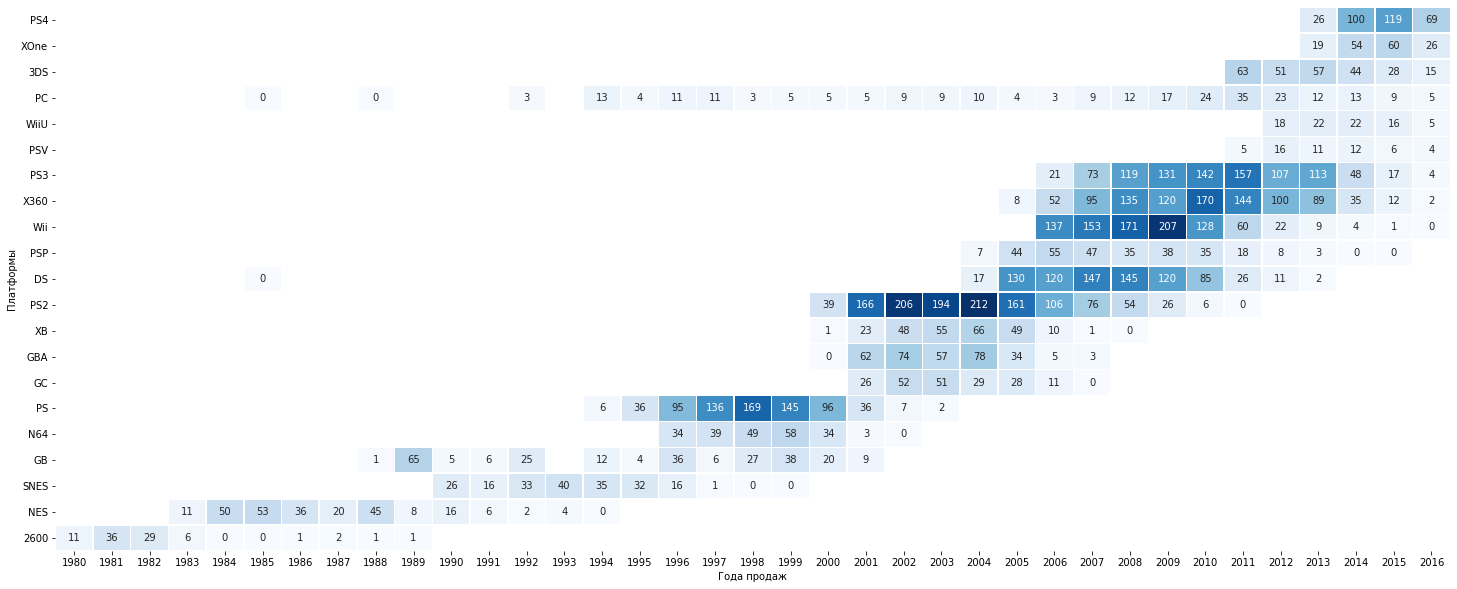

In [26]:
f, ax = plt.subplots(figsize=(25, 10))
sns.heatmap(platform_ttl_sales, annot=True, cmap='Blues', fmt='.0f', cbar=False, linewidths=.5)
ax.set_xlabel('Года продаж')
ax.set_ylabel('Платформы')
plt.show()

**Выводы**
1. Срок жизни платформ составляет в среднем от 8 до 12 лет, но наиболее активные продажи укладываются примерно в 5-6 лет.
2. Пик продаж игр приходится на 3-5 годы жизни платформы.
3. В целом по всем актуальным на 2016 год платформам наблюдаются меньшие продажи игр, чем по предшественникам.

#### Дополнительный анализ

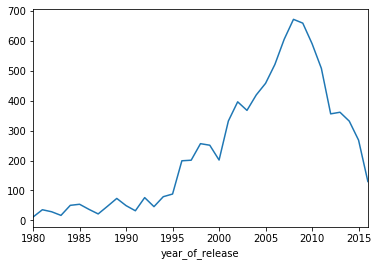

In [27]:
# общая тенденция по продажам
data.groupby('year_of_release')['ttl_sales'].sum().plot()

**Дополнительный вывод**

Малый объём релизов после 2012 года не компенсируется увеличением продаж.

### Определение актуального периода ретроспективных данных для анализа стратегии на 2017 год. Выбор потенциально прибыльных платформ.

Исходя из данных пунктов 3.1 и 3.2 можно сделать следующие выводы:
1. Все платформы, кроме PS4, XOne, 3DS, PC, PS3, X360, WiiU, PSV уже неактуальны. При этом PS3, X360 доживают свой век, жизненный цикл PSV также подходит к концу.
2. Судя по ретроспективным данным, спад продаж вызван не сколько сменой платформ, сколько общим снижением числа выпускаемых игр.
3. Актуальным периодом для анализа будет **2012-2016** годы.

In [28]:
data = data.query('year_of_release >= 2012').reset_index(drop=True)

In [29]:
data['platform'].value_counts()  # проверяем, как каждая из оставшихся платформ представлена в выборке

PS3     493
PSV     411
3DS     396
PS4     392
X360    292
PC      250
XOne    247
PSP     173
WiiU    147
Wii      54
DS       31
Name: platform, dtype: int64

### Анализ актуальных платформ


In [30]:
display(data)  # выводим данные для ознакомления
print(data.info())  # выводим общую информацию о датасете
display(data.describe().T)  # выводим статистическую информацию о датасете

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,ttl_sales
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.00,8.20,M,21.05
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.00,8.10,M,16.27
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,nan,nan,NR,14.63
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,nan,nan,NR,14.60
4,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.00,5.30,M,13.79
...,...,...,...,...,...,...,...,...,...,...,...,...
2881,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,nan,nan,NR,0.01
2882,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,nan,nan,NR,0.01
2883,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,nan,nan,NR,0.01
2884,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,nan,nan,NR,0.01


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2886 entries, 0 to 2885
Data columns (total 12 columns):
name               2886 non-null object
platform           2886 non-null object
year_of_release    2886 non-null int64
genre              2886 non-null object
na_sales           2886 non-null float64
eu_sales           2886 non-null float64
jp_sales           2886 non-null float64
other_sales        2886 non-null float64
critic_score       1312 non-null float64
user_score         1531 non-null float64
rating             2886 non-null object
ttl_sales          2886 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 270.7+ KB
None


,count,mean,std,min,25%,50%,75%,max
year_of_release,2886.00,2013.92,1.41,2012.00,2013.00,2014.00,2015.00,2016.00
na_sales,2886.00,0.20,0.57,0.00,0.00,0.03,0.17,9.66
eu_sales,2886.00,0.18,0.51,0.00,0.00,0.03,0.14,9.09
jp_sales,2886.00,0.07,0.24,0.00,0.00,0.01,0.05,4.39
other_sales,2886.00,0.05,0.16,0.00,0.00,0.01,0.04,3.96
critic_score,1312.00,72.26,12.69,13.00,66.00,74.00,81.00,97.00
user_score,1531.00,6.64,1.57,0.20,5.80,7.00,7.80,9.30
ttl_sales,2886.00,0.50,1.25,0.01,0.04,0.12,0.43,21.05


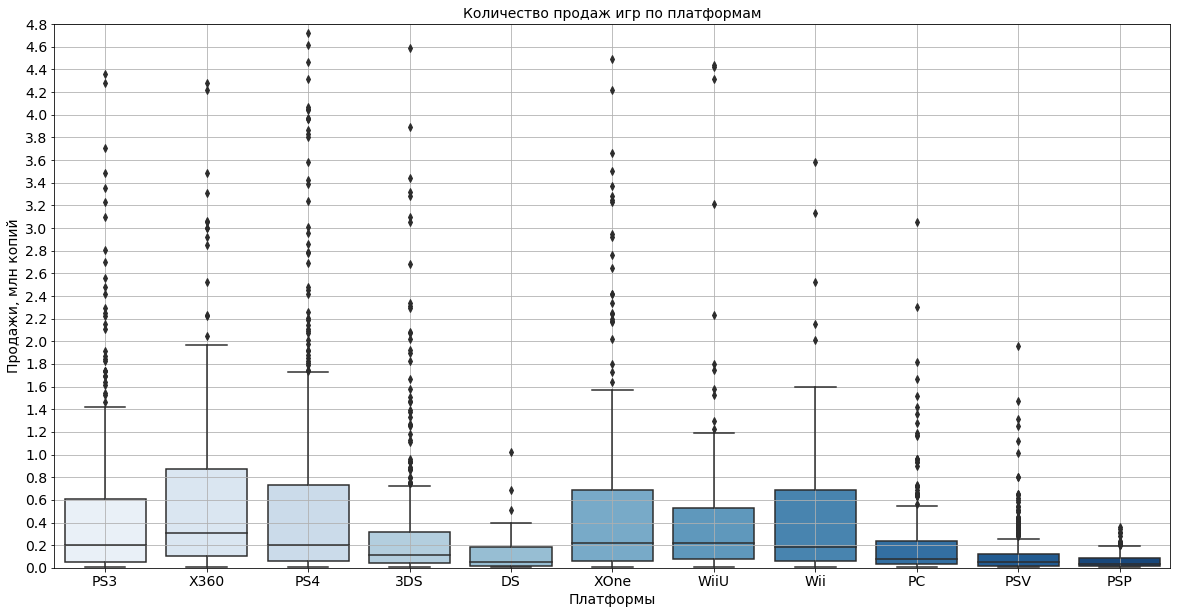

In [31]:
plt.figure(figsize=(20, 10))
sns.boxplot(x=data['platform'],
            y=data['ttl_sales'],
            palette="Blues")
plt.grid(True)
plt.ylim(0, 2)
plt.yticks([x/100 for x in range(0, 500, 20)])
plt.xlabel('Платформы', fontsize=14)
plt.ylabel('Продажи, млн копий', fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title('Количество продаж игр по платформам', fontsize=14)
plt.show()

In [32]:
data.query('ttl_sales > 5').pivot_table(index='name',
                                        columns='platform',
                                        values='ttl_sales',
                                        aggfunc='sum')

platform,3DS,DS,PC,PS3,PS4,Wii,WiiU,X360,XOne
name,,,,,,,,,
Animal Crossing: New Leaf,9.17,nan,nan,nan,nan,nan,nan,nan,nan
Assassin's Creed III,nan,nan,nan,6.44,nan,nan,nan,5.29,nan
Call of Duty: Advanced Warfare,nan,nan,nan,nan,7.66,nan,nan,nan,5.26
Call of Duty: Black Ops 3,nan,nan,nan,nan,14.63,nan,nan,nan,7.39
Call of Duty: Black Ops II,nan,nan,nan,13.79,nan,nan,nan,13.68,nan
Call of Duty: Ghosts,nan,nan,nan,9.36,nan,nan,nan,10.24,nan
Destiny,nan,nan,nan,nan,5.64,nan,nan,nan,nan
Diablo III,nan,nan,5.14,nan,nan,nan,nan,nan,nan
FIFA 14,nan,nan,nan,6.46,nan,nan,nan,nan,nan


**Выводы**
1. В среднем каждая игра продается тиражом менее от 100 до 300 тыс. копий.
2. Наиболее плохие продажи показывают игры для PC и 3DS.
3. Средние продажи игр для PS4 и XOne примерно на одинаковом уровне.
4. Для каждой платформы существуют игры-хиты, расходящиеся милионными тиражами. Наиболее это заметно для платформ PS3, X360, PS4, XOne, 3DS. Некоторые из таких игр представлены на нескольких платформах, например, Grand Theft Auto V, Assassin's Creed III или FIFA Soccer 13. Однако тираж большинства игр не превышает 1 млн экземпляров.

### Влияние отзывов критиков и пользователей

Оценим число отзывов пользователей и критиков к общему объему продаж.

In [33]:
data.groupby('platform')['critic_score', 'user_score', 'ttl_sales'].count()

,critic_score,user_score,ttl_sales
platform,,,
3DS,104,114,396
DS,1,3,31
PC,198,206,250
PS3,214,283,493
PS4,252,257,392
PSP,1,4,173
PSV,107,130,411
Wii,5,17,54
WiiU,90,100,147


In [34]:
# приведем оценку критиков в ту же размерность, что и оценку пользователей
data['critic_score'] = data['critic_score'] / 10

In [35]:
def corr_analysis(platform):
    print(f'Платформа: {platform}')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
    sns.scatterplot(x='critic_score',
                    y='ttl_sales',
                    data=data[data['platform'] == platform],
                    palette='Blues',
                    ax=ax1,
                    alpha=0.5)
    sns.scatterplot(x='user_score',
                    y='ttl_sales',
                    data=data[data['platform'] == platform],
                    palette='Blues',
                    ax=ax2,
                    alpha=0.5)
    ax1.grid(True)
    ax1.set_xlabel('Оценка критиков', fontsize=14)
    ax1.set_ylabel('Объем продаж', fontsize=14)
    ax1.set_xlim(0, 10)
    ax1.tick_params(axis='both', labelsize=14)
    ax2.grid(True)
    ax2.set_xlim(0, 10)
    ax2.set_xlabel('Оценка пользователей', fontsize=14)
    ax2.set_ylabel('Объем продаж', fontsize=14)
    ax2.tick_params(axis='both', labelsize=14)
    plt.show()
    print(f"Корреляция между оценками критиков и объемом продаж: {data[data['platform'] == platform]['ttl_sales'].corr(data[data['platform'] == platform]['critic_score']):.3f}")
    print(f"Корреляция между оценками пользователей и объемом продаж: {data[data['platform'] == platform]['ttl_sales'].corr(data[data['platform'] == platform]['user_score']):.3f}")
    print()

Платформа: PS3


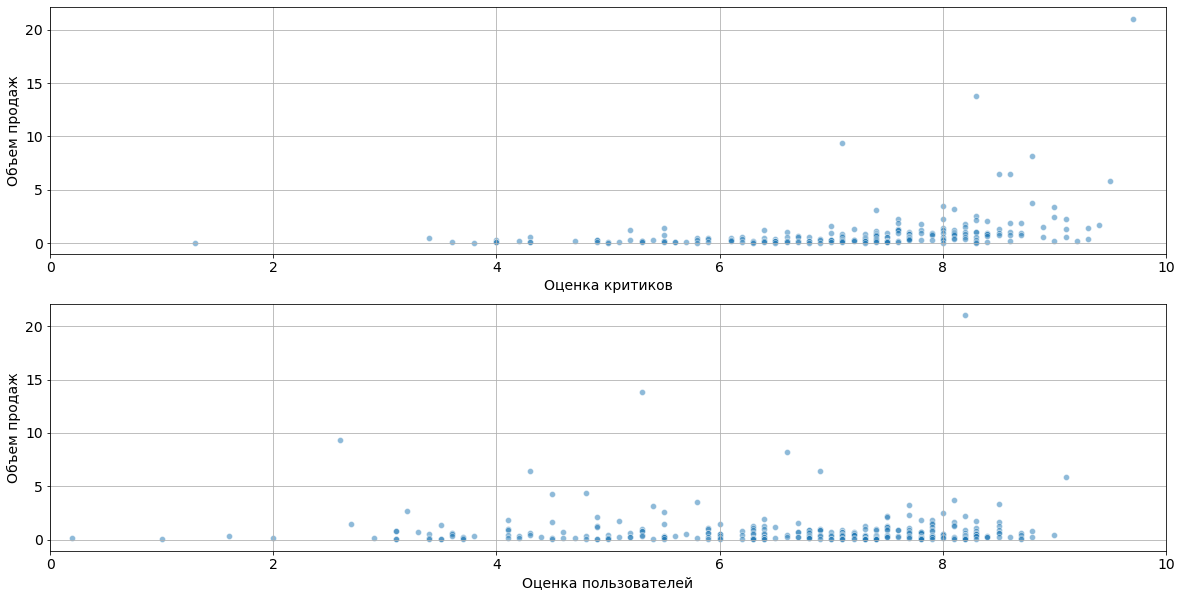

Корреляция между оценками критиков и объемом продаж: 0.331
Корреляция между оценками пользователей и объемом продаж: -0.005

Платформа: X360


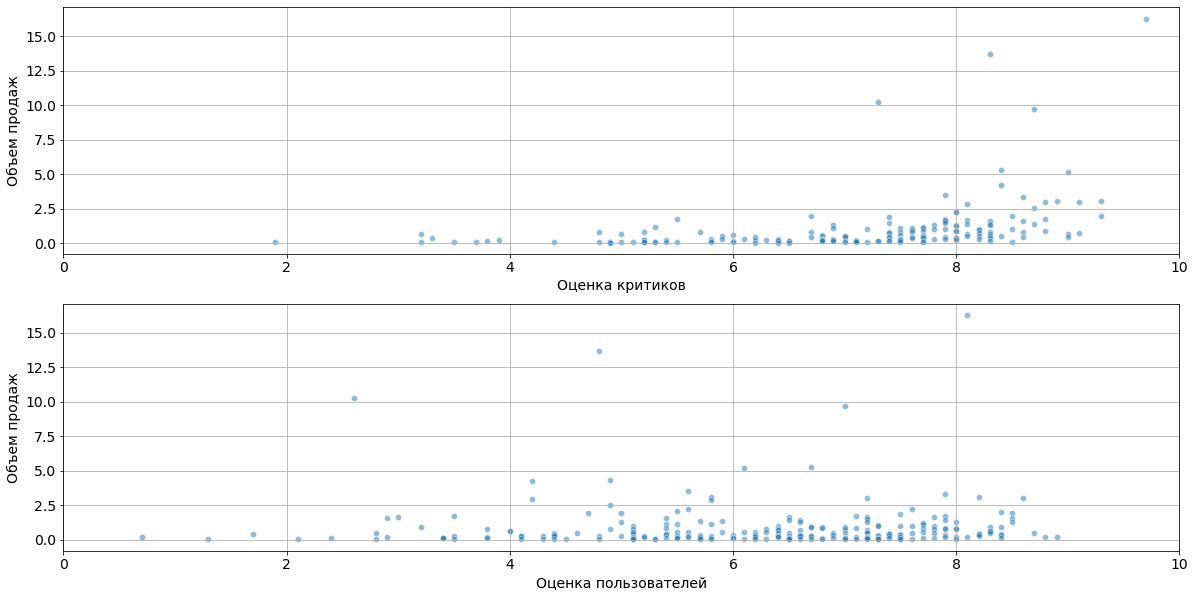

Корреляция между оценками критиков и объемом продаж: 0.361
Корреляция между оценками пользователей и объемом продаж: 0.006

Платформа: PS4


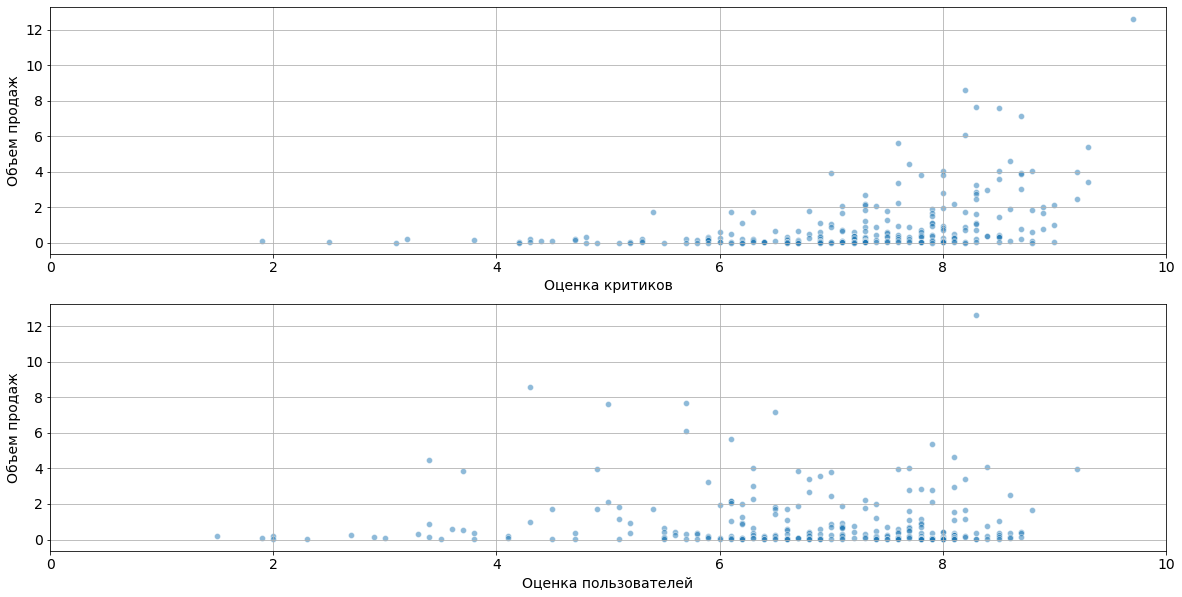

Корреляция между оценками критиков и объемом продаж: 0.407
Корреляция между оценками пользователей и объемом продаж: -0.032

Платформа: 3DS


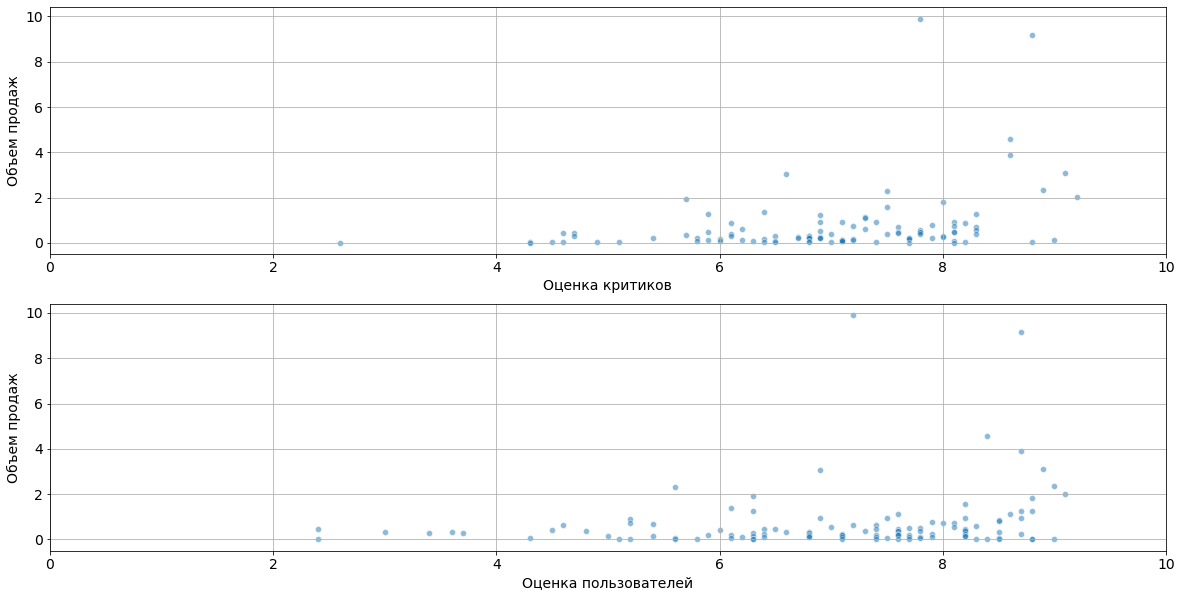

Корреляция между оценками критиков и объемом продаж: 0.321
Корреляция между оценками пользователей и объемом продаж: 0.198

Платформа: DS


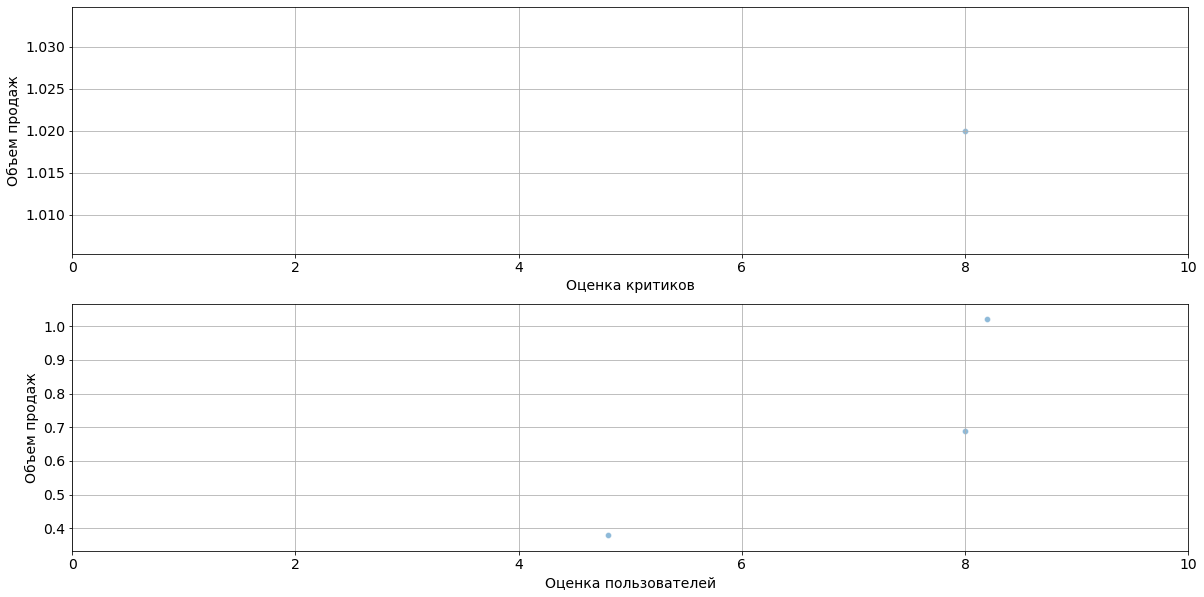

Корреляция между оценками критиков и объемом продаж: nan
Корреляция между оценками пользователей и объемом продаж: 0.883

Платформа: XOne


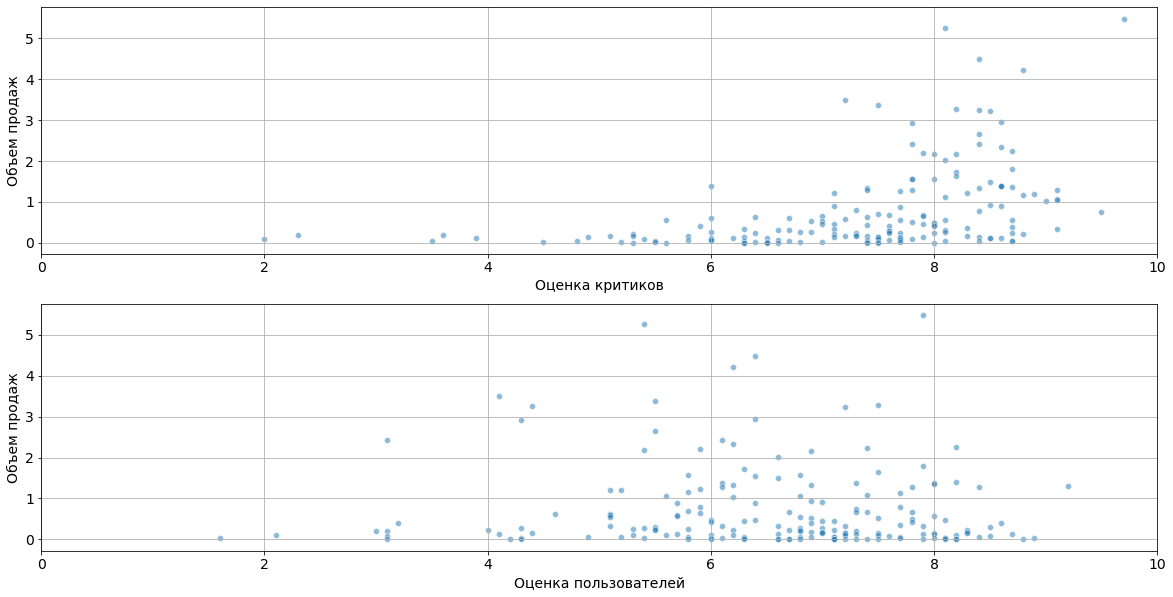

Корреляция между оценками критиков и объемом продаж: 0.417
Корреляция между оценками пользователей и объемом продаж: -0.069

Платформа: WiiU


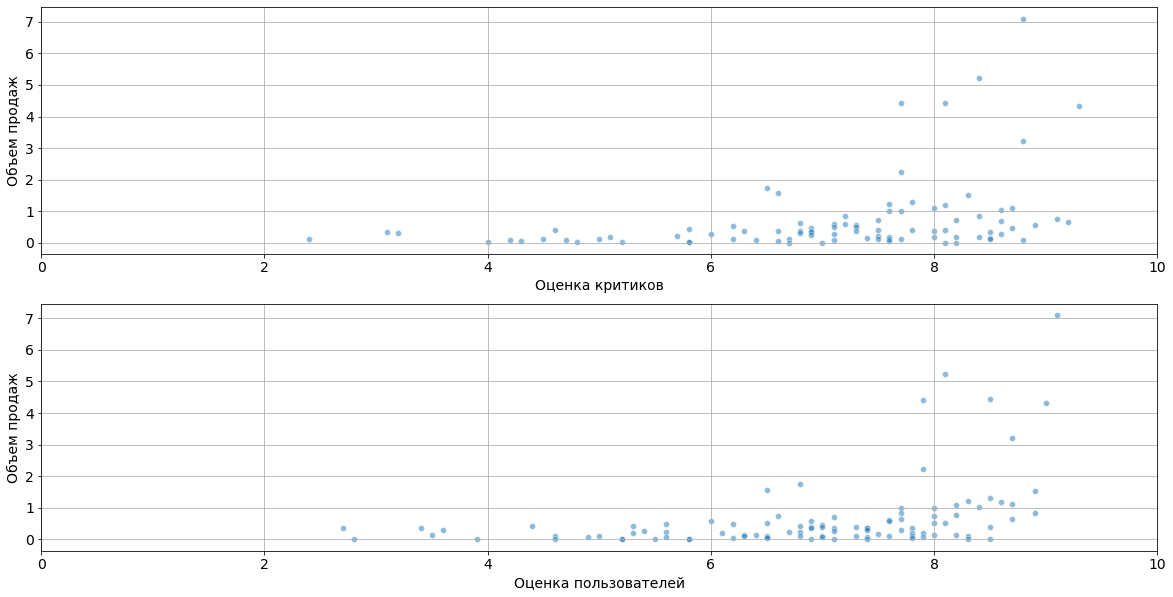

Корреляция между оценками критиков и объемом продаж: 0.348
Корреляция между оценками пользователей и объемом продаж: 0.400

Платформа: Wii


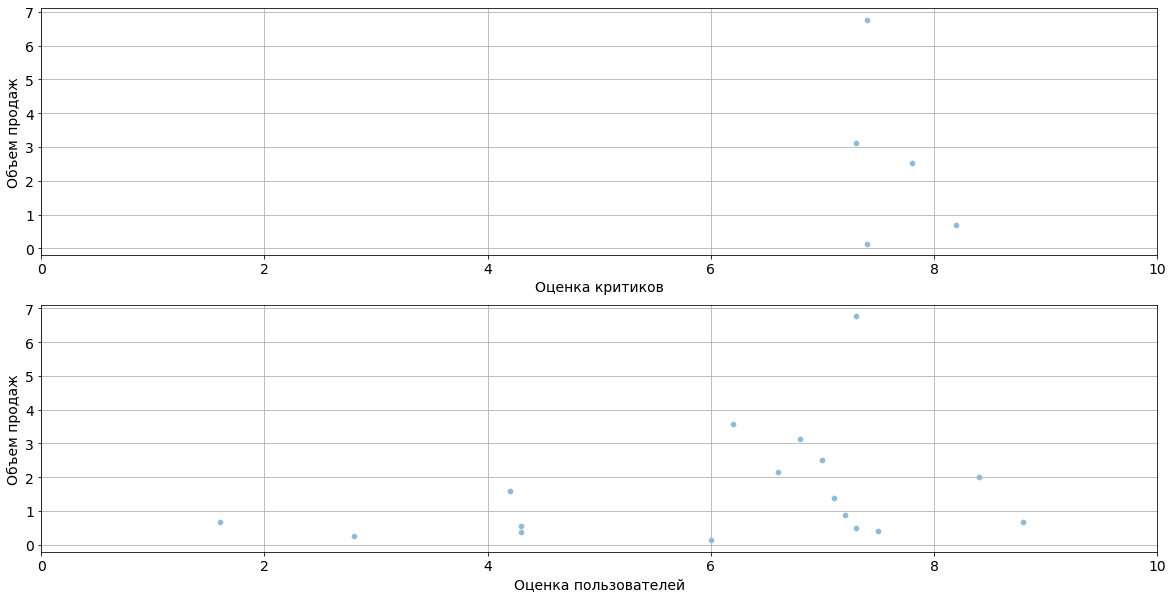

Корреляция между оценками критиков и объемом продаж: -0.424
Корреляция между оценками пользователей и объемом продаж: 0.296

Платформа: PC


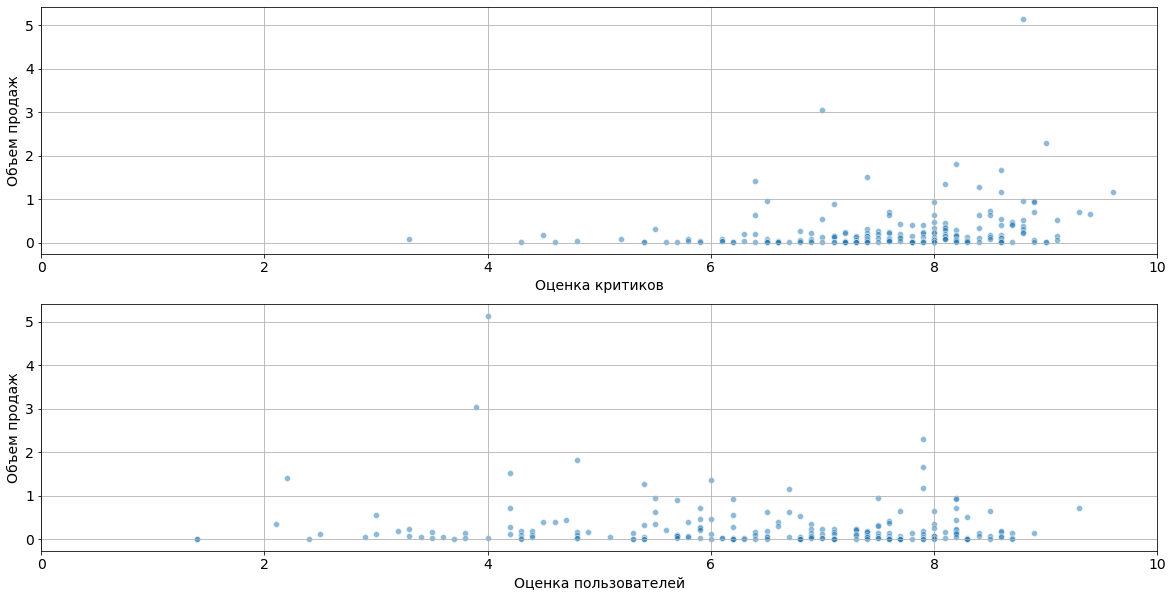

Корреляция между оценками критиков и объемом продаж: 0.237
Корреляция между оценками пользователей и объемом продаж: -0.122

Платформа: PSV


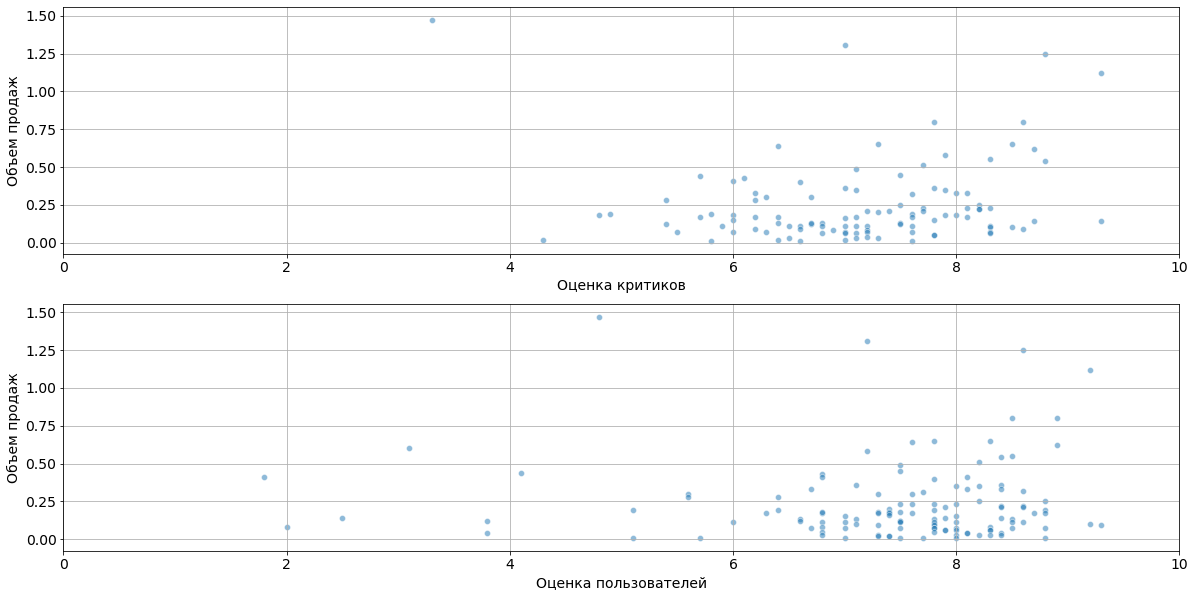

Корреляция между оценками критиков и объемом продаж: 0.094
Корреляция между оценками пользователей и объемом продаж: -0.004

Платформа: PSP


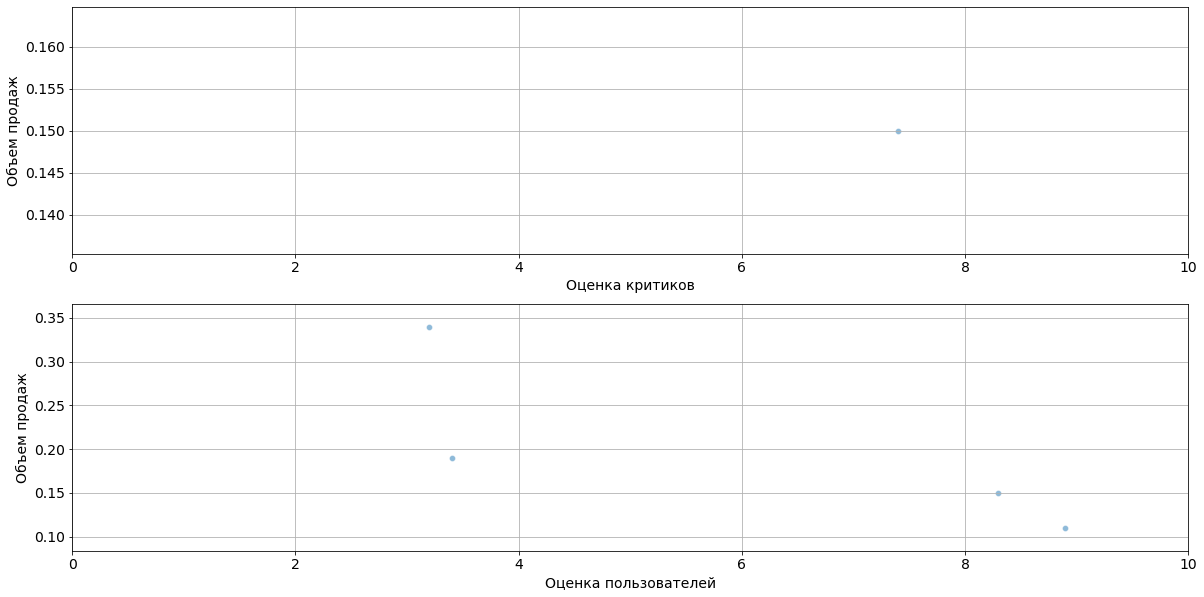

Корреляция между оценками критиков и объемом продаж: nan
Корреляция между оценками пользователей и объемом продаж: -0.802



In [36]:
for plat in data['platform'].unique():
    corr_analysis(plat)

**Выводы**
1. Между оценками критиков и объемами продаж существует слабая корреляция.
2. Оценки пользователей и объемы продаж корреляции между собой не имеют.
3. Ситуация в целом не меняется в зависимости от платформы.
4. Более-менее заметные продажи набирают игры, получившие не менее 5 баллов по оценкам пользователей и критиков
5. На более позних платформах корреляция между отзывами критиков и объемами продаж сильнее.

### Анализ распределения по жанрам

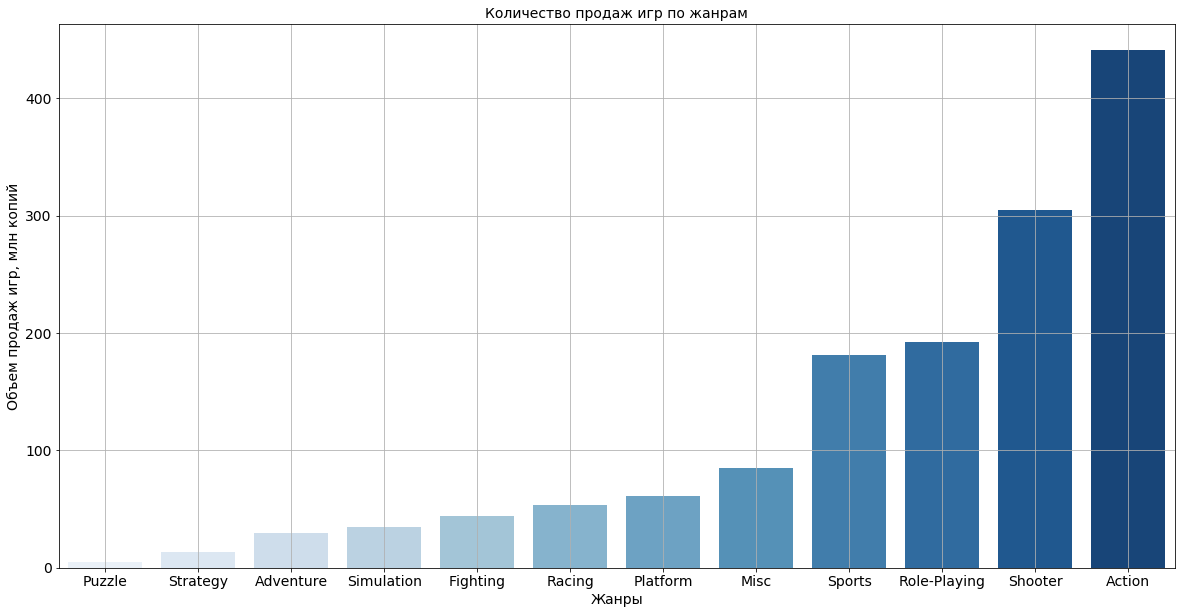

In [37]:
platform_ttl_sales = data.groupby('genre')['ttl_sales'].sum().sort_values()
plt.figure(figsize=(20, 10))
sns.barplot(x=platform_ttl_sales.index,
            y=platform_ttl_sales,
            palette='Blues')
plt.grid(True)
plt.xlabel('Жанры', fontsize=14)
plt.ylabel('Объем продаж игр, млн копий', fontsize=14)
plt.title('Количество продаж игр по жанрам', fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.show()

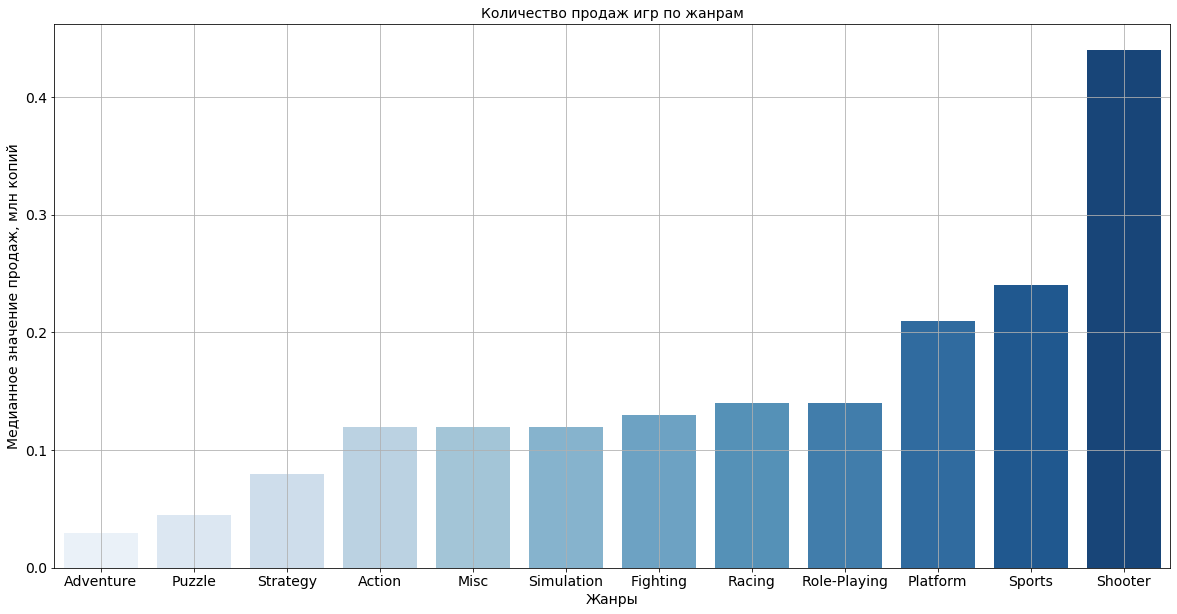

In [38]:
platform_ttl_sales = data.groupby('genre')['ttl_sales'].median().sort_values()
plt.figure(figsize=(20, 10))
sns.barplot(x=platform_ttl_sales.index,
            y=platform_ttl_sales,
            palette='Blues')
plt.grid(True)
plt.xlabel('Жанры', fontsize=14)
plt.ylabel('Медианное значение продаж, млн копий', fontsize=14)
plt.title('Количество продаж игр по жанрам', fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.show()

In [39]:
platform_ttl_sales = data.pivot_table(index='platform',
                                      columns='genre',
                                      values='ttl_sales',
                                      aggfunc=(sum))

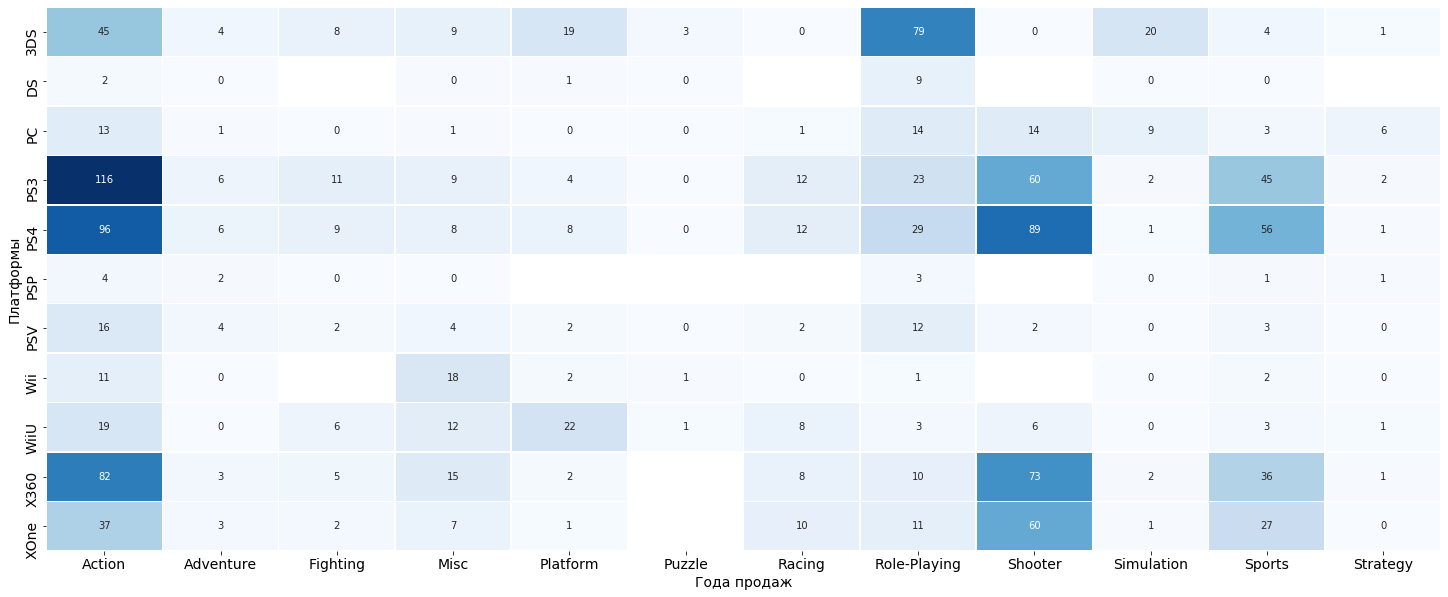

In [40]:
f, ax = plt.subplots(figsize=(25, 10))
sns.heatmap(platform_ttl_sales,
            annot=True,
            cmap='Blues',
            fmt='.0f',
            cbar=False,
            linewidths=.5)
ax.set_xlabel('Года продаж', fontsize=14)
ax.set_ylabel('Платформы', fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.show()

In [41]:
platform_ttl_sales = data.pivot_table(index='platform',
                                      columns='genre',
                                      values='ttl_sales',
                                      aggfunc='median')

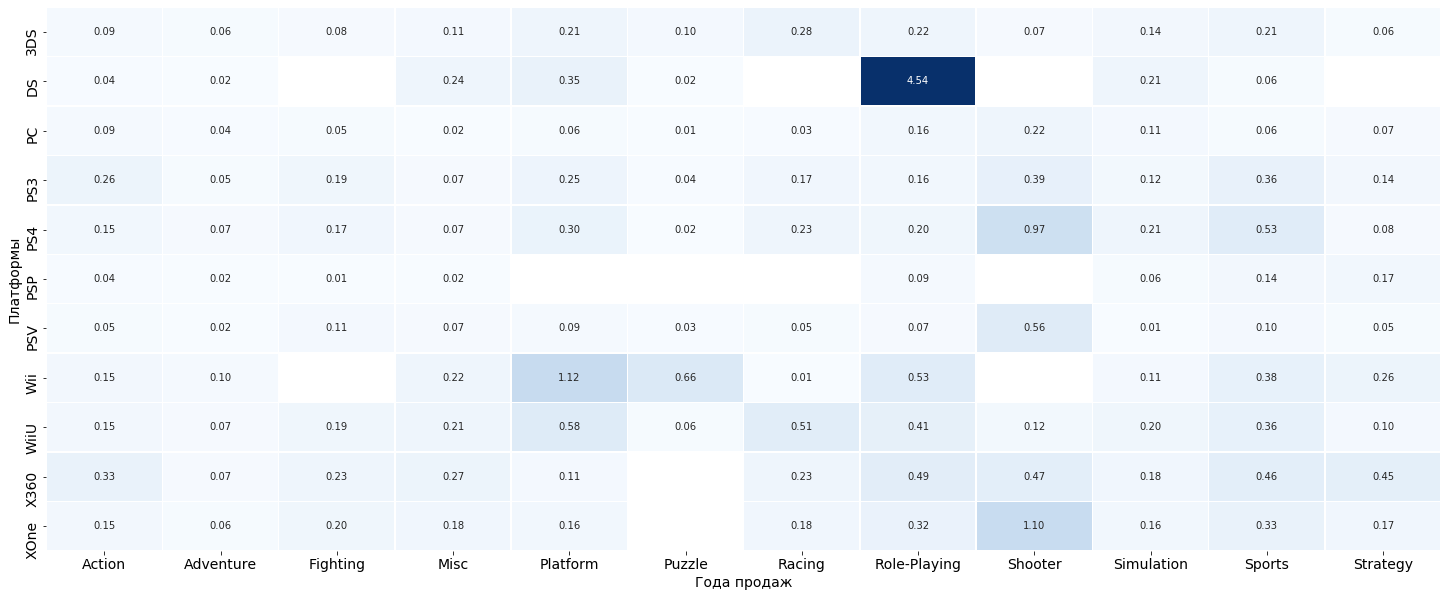

In [42]:
f, ax = plt.subplots(figsize=(25, 10))
sns.heatmap(platform_ttl_sales,
            annot=True,
            cmap='Blues',
            fmt='.2f',
            cbar=False,
            linewidths=.5)
ax.set_xlabel('Года продаж', fontsize=14)
ax.set_ylabel('Платформы', fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.show()

**Выводы**
1. Наиболее популярными выпускаемыми жанрами являются `Action` и `Shooter`. Исключением являются портативные консоли, а также платформы со специфическим управлением.
2. Наибольшие продажи, как правило, показывают игры из жанра `Shooter`, `Sports`, `Platform`, `Role-Playing`, `Racing`.
    1. `Shooter` хорошо продается на XOne, PS4, PS3, PSV, X360, PC
    2. `Sports` хорошо продается на PS4, X360, Wii, WiiU, PS3, XOne, 3DS
    3. `Platform` хорошо продается на Wii, WiiU, DS, PS4, PS3
    4. `Role-Playing` хорошо продается на DS, Wii, X360, WiiU, XOne, 3DS
    5. `Racing` хорошо продается на WiiU, PS4.
3. Остальные жанры сильно проигрывают в популярности.
4. Самым непопулярным жанром является жанр `Puzzle`, хотя для платформы Wii его продажи высоки.

## Анализ по регионам

Определите для пользователя каждого региона (NA, EU, JP):
* Самые популярные платформы (топ-5). Опишите различия в долях продаж.
* Самые популярные жанры (топ-5). Поясните разницу.
* Влияет ли рейтинг ESRB на продажи в отдельном регионе?

*Честно говоря, не нашёл способа построить в Seaborn столбчатые диаграммы с группировкой из исходного датасета, когда данные в разных столбцах. Для удобства создал дополнительную таблицу.*

In [43]:
data_by_region_na = data[['na_sales', 'platform', 'genre','rating']]
data_by_region_na.loc[:, 'region'] = 'North America'
data_by_region_na.columns = ['sales', 'platform', 'genre','rating', 'region']
data_by_region_eu = data[['eu_sales', 'platform', 'genre','rating']]
data_by_region_eu.loc[:, 'region'] = 'Europe'
data_by_region_eu.columns = ['sales', 'platform', 'genre','rating', 'region']
data_by_region_jp = data[['jp_sales', 'platform', 'genre','rating']]
data_by_region_jp.loc[:, 'region'] = 'Japan'
data_by_region_jp.columns = ['sales', 'platform', 'genre','rating', 'region']
data_by_region = pd.concat([data_by_region_na, data_by_region_eu, data_by_region_jp]).reset_index(drop=True)

In [44]:
data_by_region

,sales,platform,genre,rating,region
0,7.02,PS3,Action,M,North America
1,9.66,X360,Action,M,North America
2,6.03,PS4,Shooter,NR,North America
3,5.28,3DS,Role-Playing,NR,North America
4,4.99,PS3,Shooter,M,North America
...,...,...,...,...,...
8653,0.01,PSV,Adventure,NR,Japan
8654,0.01,PSV,Misc,NR,Japan
8655,0.01,PS3,Action,NR,Japan
8656,0.01,PSV,Adventure,NR,Japan


In [45]:
data_by_region.pivot_table(index='platform', columns='region', values='sales', aggfunc='sum')

region,Europe,Japan,North America
platform,,,
3DS,42.64,87.79,55.31
DS,3.53,3.72,4.59
PC,37.76,0.00,19.12
PS3,106.86,35.29,103.38
PS4,141.09,15.96,108.74
PSP,0.42,10.47,0.13
PSV,11.36,21.04,10.98
Wii,11.92,3.39,17.45
WiiU,25.13,13.01,38.10


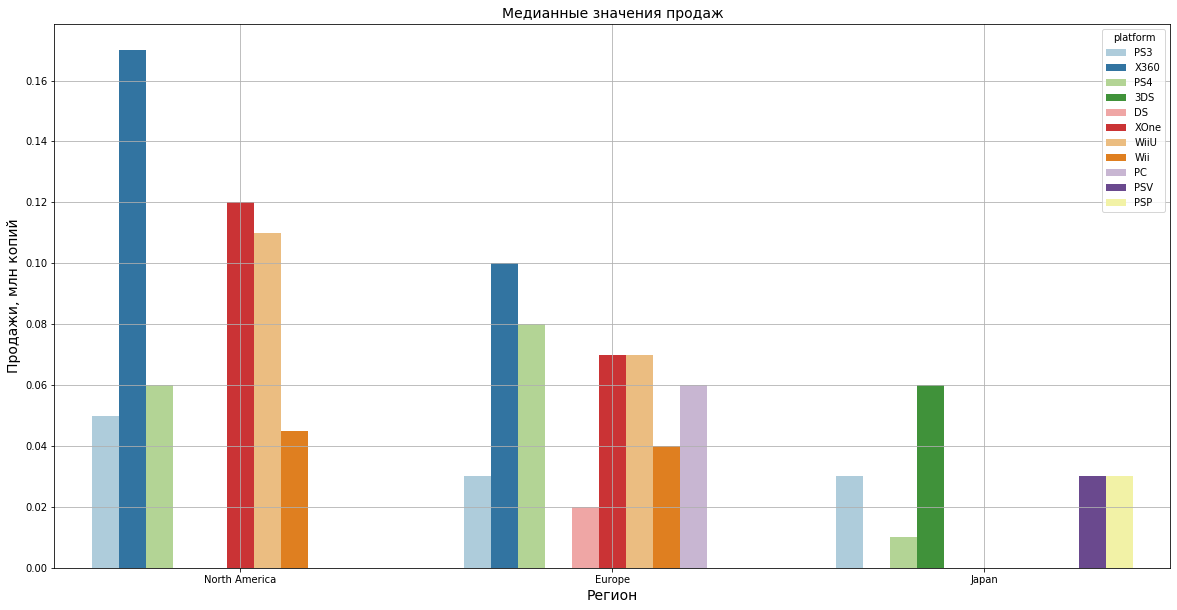

In [46]:
fig, ax = plt.subplots(1, 1, figsize = (20,10))
sns.barplot(x='region',
            y='sales',
            hue='platform',
            data=data_by_region,
            estimator=np.median,
            ax=ax,
            ci=None,
            palette='Paired')
ax.set_xlabel('Регион', fontsize=14)
ax.set_ylabel('Продажи, млн копий', fontsize=14)
ax.grid(True)
plt.title('Медианные значения продаж', fontsize=14)
plt.show()

**Выводы**
1. Рынки Северной Америки и Европы в целом похожи. В Северной Америке сильные позиции имеет XOne, в Европе предпочтение отдают PS4.
2. Игры для PC популярны в Европе.
3. Японский рынок очень сильно скошен в сторону портативных консолей. Популярны 3DS, PSV и PSP. Также сильные позиции имеют PS3  и PS4. X360 и XOne отсутствуют на рынке.

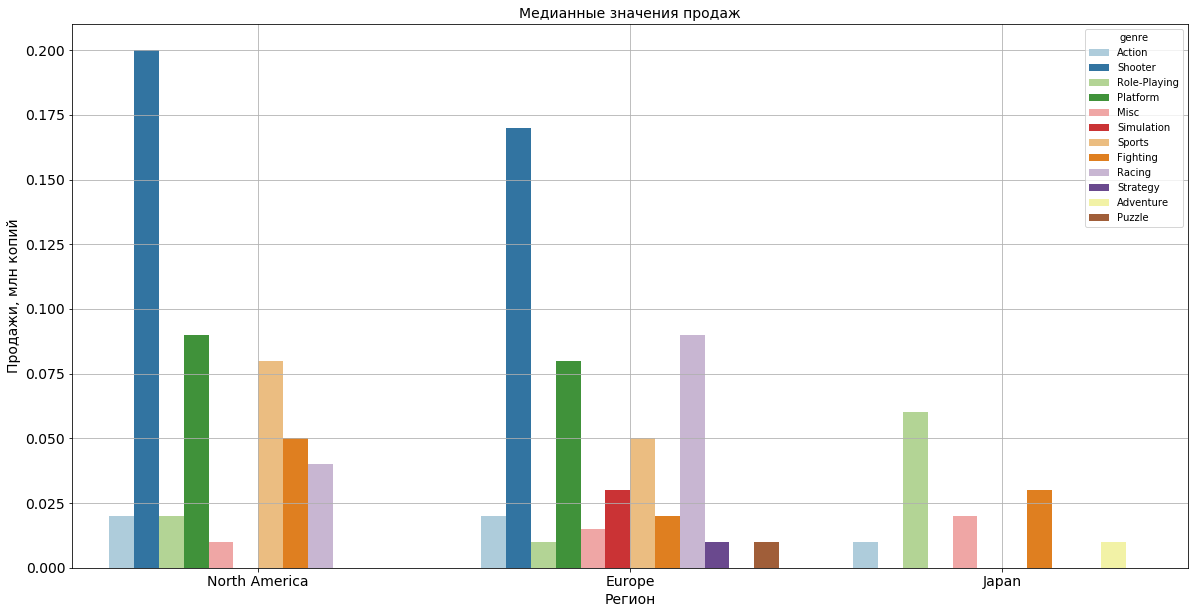

In [47]:
fig, ax = plt.subplots(1, 1, figsize = (20,10))
sns.barplot(x='region',
            y='sales',
            hue='genre',
            data=data_by_region,
            estimator=np.median,
            ax=ax,
            ci=None,
            palette='Paired')
ax.set_xlabel('Регион', fontsize=14)
ax.set_ylabel('Продажи, млн копий', fontsize=14)
ax.tick_params(axis='both', labelsize=14)
ax.grid(True)
plt.title('Медианные значения продаж', fontsize=14)
plt.show()

**Выводы**
1. Самыми продаваемыми жанром на европейском и североамериканском рынках является `Shooter`.
2. На японском рынке первое место по медианным продажам занимает жанр `Role-Plaing`.
3. На европейском рынке следующими по популярности идут жанры `Racing` и `Platform`.
4. На североамериканском рынке следующими по популярности идут `Platform` и `Sports`
5. На японском рынке также популярными являются `Fighting` и `Misc`.

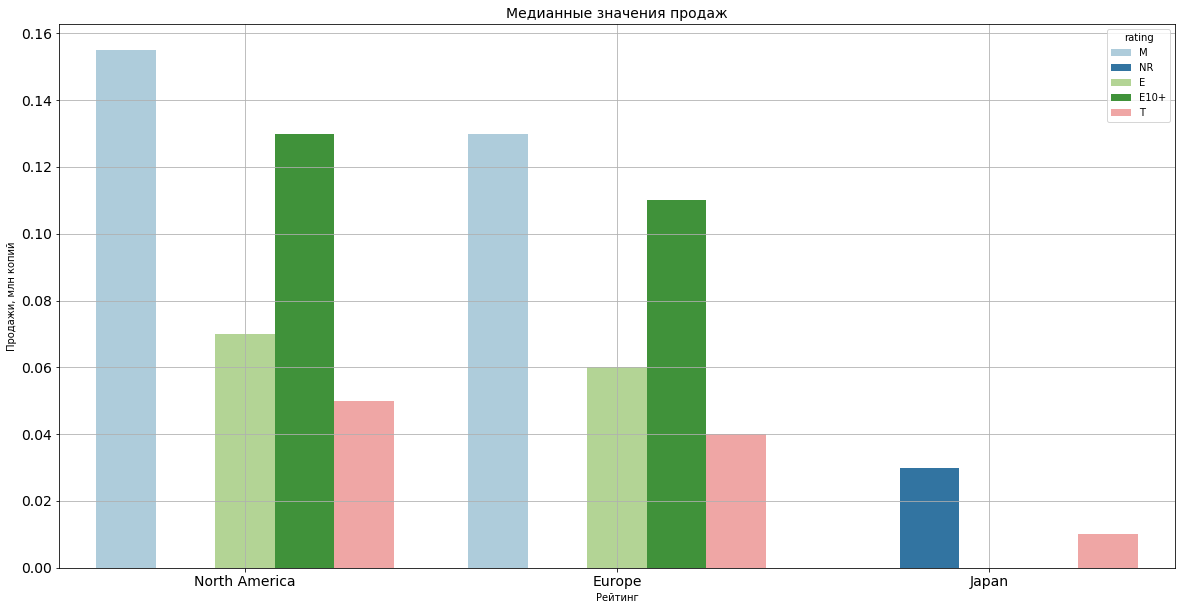

In [48]:
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(x='region',
            y='sales',
            hue='rating',
            data=data_by_region,
            estimator=np.median,
            ax=ax,
            ci=None,
            palette='Paired')
ax.set_xlabel('Рейтинг')
ax.set_ylabel('Продажи, млн копий')
plt.title('Медианные значения продаж', fontsize=14)
ax.grid(True)
plt.tick_params(axis='both', labelsize=14)
plt.show()

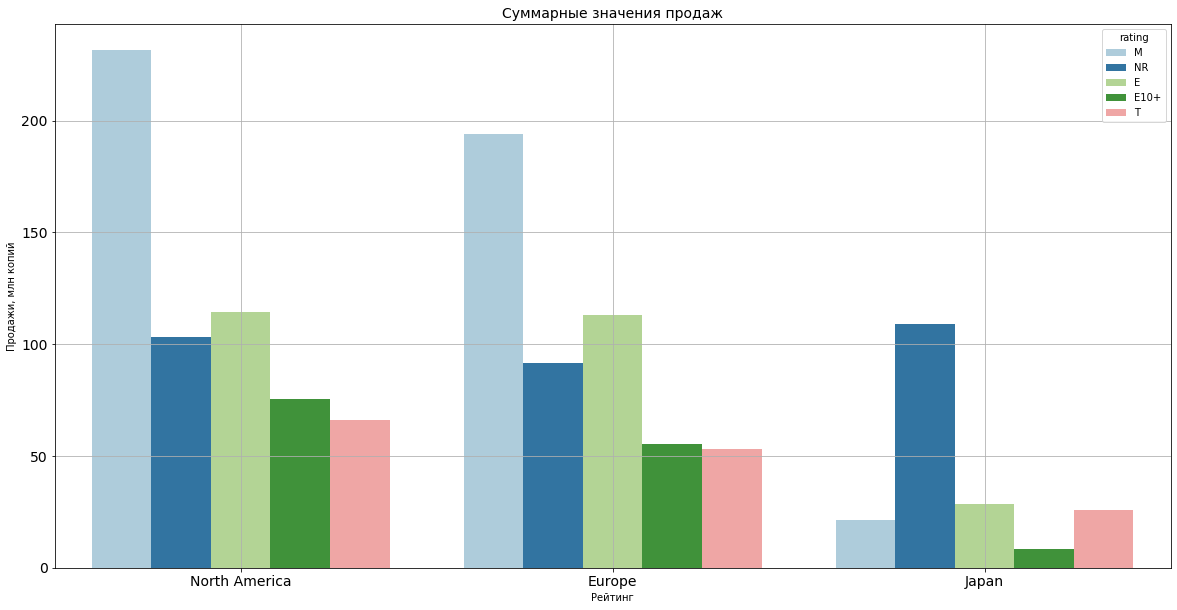

In [49]:
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(x='region',
            y='sales',
            hue='rating',
            data=data_by_region,
            estimator=sum,
            ax=ax,
            ci=None,
            palette='Paired')
ax.set_xlabel('Рейтинг')
ax.set_ylabel('Продажи, млн копий')
plt.title('Суммарные значения продаж', fontsize=14)
ax.grid(True)
plt.tick_params(axis='both', labelsize=14)
plt.show()

**Выводы**
1. В Японии наибольшие продажи имеют игры с отсутствующими возрастным рейтингом, а также игры для подростков от 13 до 19 лет. Остальные игры с рейтингами на рынке представлены, но особых тиражей не имеют. Возможно, распространены игры для локального рынка, которые не оцениваются ESRB.
2. На рынках Северной Америки и Европы игры без возрасного рейтинга не имеют больших продаж, хотя представлены в большом количестве. По продажам лидируют игры для лиц от 17 лет. Что логично, так как данный рейтинг чаще присваивают популярному на этих рынках жанру `Shooter` и `Figting`. Также популярны игры с рейтингами "для всех старше 10 лет", "для всех" и "для подростков от 13 до 19 лет", которые присваиваются, скорее всего, для жанров `Racing`, `Sports` и `Platform`. 

## Проверка гипотез

### Нулевая гипотеза "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые"
Альтернативная гипотеза "Средние пользовательские рейтинги платформ Xbox One и PC отличаются"

Подготовим две выбоки: пользовательские отзывы на PC и пользовательсткие отзывы на Xbox One

In [50]:
data_sample_pc = data[(data['platform'] == 'PC') & (~data['user_score'].isna())]['user_score']
data_sample_xone = data[(data['platform'] == 'XOne') & (~data['user_score'].isna())]['user_score']
print(data_sample_pc.shape, data_sample_xone.shape)

(206,) (182,)


In [51]:
alpha = .05
results = st.ttest_ind(data_sample_pc,
                       data_sample_xone, equal_var = False)
print(f'p-значение: {results.pvalue:.2%}' )
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 54.90%
Не получилось отвергнуть нулевую гипотезу


**Вывод**

Есть вероятность выше порогового значения 5%, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые. В связи с этим, отбрасываем нулевую гипотезу и оставляем альтернативную - "Средние пользовательские рейтинги платформ Xbox One и PC различаются".

#### Дополнительная нулевая гипотеза "Средние пользовательские рейтинги платформ Xbox One и PC для одних и тех же игр одинаковые"
Альтернативная гипотеза "Средние пользовательские рейтинги платформ Xbox One и PC для одних и тех же игр отличаются"

In [52]:
data_sample = data.pivot_table(index='name', columns='platform', values='user_score')

In [53]:
data_sample = data_sample[~data_sample['PC'].isna() & ~data_sample['XOne'].isna()][['PC','XOne']]

In [54]:
data_sample.head(10)

platform,PC,XOne
name,,
Alien: Isolation,8.40,7.80
Assassin's Creed IV: Black Flag,7.70,7.40
Assassin's Creed Syndicate,5.90,6.10
Assassin's Creed: Unity,3.00,4.10
Batman: Arkham Knight,2.50,6.60
Battleborn,6.90,7.20
Battlefield 1,7.60,8.20
Battlefield 4,6.00,6.60
Battlefield: Hardline,3.80,5.10


In [55]:
alpha = .05
results = st.ttest_ind(data_sample['XOne'],
                       data_sample['PC'],
                       equal_var = True)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.018149532130164285
Отвергаем нулевую гипотезу


**Дополнительный вывод**

Несмотря на то, что мы не смогли отбросить гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые, вероятность гипотезы "Средние пользовательские рейтинги платформ Xbox One и PC для одних и тех же игр одинаковые" меньше порогового значения. Принимаем альтернативную гипотезу "Средние пользовательские рейтинги платформ Xbox One и PC для одних и тех же игр отличаются"

### Альтернативная гипотеза "Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные"
Нулевая гипотеза "Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые"

In [56]:
data_sample_action = data[(data['genre'] == 'Action') & (~data['user_score'].isna())]['user_score']
data_sample_sports = data[(data['genre'] == 'Sports') & (~data['user_score'].isna())]['user_score']
print(data_sample_action.shape, data_sample_sports.shape)

(523,) (195,)


In [57]:
alpha = .05
results = st.ttest_ind(data_sample_action,
                       data_sample_sports,
                       equal_var = False)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  4.24307776572644e-20
Отвергаем нулевую гипотезу


**Вывод**

Вероятность того, что пользовательские рейтинги жанров Action и Sports одинаковые крайне мала. В связи с этим, принимаем альтернативную гипотезу "Средние пользовательские рейтинги жанров Action и Sports разные".

## Общий вывод

1. Наблюдается тенденция к снижению числа выходящих игр и соответственно объёмов продаж.
2. В наиболее перспективными по продажам платформами являются Xbox One, PS4 и, отчасти, Nintendo 3DS. Остальные платформы или имеют меньшие продажи (PC), либо завершили свой жизненный цикл (PS3, Xbox 360).
3. В качестве актуального периода для анализа принят период с 2012 по 2016 годы.
4. В среднем игры продаются тиражом 200 тыс. копий. Большинство игр не продается тиражем более 1 млн копий, однако есть игры разошедшиеся тиражами свыше 5 млн копий.
5. Отзывы пользователей никак не влияют на продажи игр - пользователи оставляют отзывы после того как купили игру.
6. Отзывы критиков имеют слабую кореляцию с продажами - критики имеют возможность оценить игру заранее, некоторые пользователи прислушиваются к их мнению.
7. Самые популярные жанры - Shooter, Sprots и Platform - они продаются наиболее активно. Следующие по популярности спортивные Racing и Role-Playing.
8. Платформы по разному представлены на различных рынках:
    1. Основным рынком для X360 и XOne является североамериканский, на втором месте европейский. Японский рынок для этих платформ неактуален.
    2. Для PS3 и PS4 основными рынками являются как европейский, так и североамериканский. Также консоли представлены на "родном" японском рынке.
    3. WiiU популярна на всех рынках и игры имеют хорошие медианные продажи, но, скорее всего, из-за малого количества выходящих для неё игр.
    3. Консоли 3DS и PSV крайне востребованы на японском рынке.
9. Наиболее популярныt жанры на североамериканском и европейском рынках одинаковый (Shooter, Platform, Sports и Racing). Японский рынок отличается пристрастием к жанру Role-Plaing игр, при этом жанр Figting находится на втором месте.
10. На рынках Северной Америки и Европы игры без возрасного рейтинга не имеют больших продаж, хотя представлены в большом количестве. По продажам лидируют игры для лиц от 17 лет. По сути, это и есть платежеспособная целевая аудитория и данный рейтинг чаще присваивают популярному на этих рынках жанру Shooter. Также популярны игры с рейтингами "для всех старше 10 лет", "для всех" и "для подростков от 13 до 19 лет", которые присваиваются, скорее всего, для жанров Racing, Sports и Platform.
11. В Японии наибольшие продажи имеют игры с отсутствующими возрастным рейтингом, а также игры для подростков от 13 до 19 лет. Остальные игры с рейтингами на рынке представлены, но особых тиражей не имеют. Возможно, распространены игры для локального рынка, которые не оцениваются ESRB.
12. Не удалось отбросить гипотезу "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые". Возможно, аудитории данных платформ схожи, однако также не удалось принять гипотезу "Средние пользовательские рейтинги платформ Xbox One и PC для одних и тех же игр одинаковые".
13. Также принята альтернативная гипотеза "Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные"

Можно ожидать, что наиболее хорошие продажи покажут в 2017 году игры с хорошими отзывами критиков в жанре Shooter с рейтингом M и T, а также в жанрах Platform, Sports и Racing с рейтингами E, E10+ для рынков Северной Америки и Европы для платформ Xbox One и PS4, и игры в жанре Role-Playng для платформы 3DS для рынка Японии.